In [1]:
%matplotlib inline
from textblob import TextBlob, Word
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

# Aspect Based Sentiment Analysis (ABSA) of YouTube comments

ABSA is really interesting since it gives a deep view of the variance of sentiments within a large corpus of text. 

Most sentiment systems run sentiment analysis on the entire text, which sort of 'averages out' the sentiment. Running aspect based sentiment analysis on things like product reviews or YouTube comments can help the creators understand the specific parts that the users liked.

This is my attempt at running ABSA on the YouTube comments on Siraj Raval's *amazing* YouTube video [here](https://www.youtube.com/watch?v=si8zZHkufRY). (PS: The video is about sentiment analysis using tflearn, but I am using TextBlob in this version for quick implementation.)

Data gathered using the YouTube Data API's [commentThreads.list](https://developers.google.com/youtube/v3/docs/commentThreads/list) function.

Alright, here goes. 
(*Cracks fingers*)

In [2]:
import csv
with open('data.csv', 'r') as f:
  reader = csv.reader(f)
  result = list(reader)

result = result[0]
result[:10]

['Is any resource that shows clearer the conversion and the format of the input reviews?',
 'I subscribed because I like the content, but i think these videos are more for people who have an intermediate level understanding of python. I can follow the conceptual bits, but as soon as you start programming it with python, you explain your steps but only on a very high level.\nCould you recommend a place where I can learn programming ML by building on the fundamental concepts?\n\nbtw nice rap ;p',
 'What text editor are you using, Siraj?',
 'python version-3.6.1 ,Anaconda-4.4.0  code for this version of this tutorial-------\nhttps://github.com/ankitAMD/Ankit_Siraj5_Sentiment_Analysis/blob/master/siraj_tut-5_sentiment_analysis.ipynb\n\nhttps://github.com/ankitAMD/Ankit_Siraj5_Sentiment_Analysis',
 "lol, as an german i never used waldeinsamkeit :P i'v only used einsamkeit, without wald",
 "Just curious, how long did it take y'all to train the neural net that siraj wrote. I ran mine on a gtx

In [3]:
# Text cleaning 
from string import punctuation
import re

def clean_sentence(sentence):
    sentence = re.sub(r"(?:\@|https?\://)\S+|\n+", "", sentence.lower())
    # Fix spelling errors in comments!
    sent = TextBlob(sentence)
    sent.correct()
    clean = ""
    for sentence in sent.sentences:    
        words = sentence.words
        # Remove punctuations
        words = [''.join(c for c in s if c not in punctuation) for s in words]
        words = [s for s in words if s]
        clean += " ".join(words)
        clean += ". "
    return clean

result = [clean_sentence(x) for x in result]
result[:10]

['is any resource that shows clearer the conversion and the format of the input reviews. ',
 'i subscribed because i like the content but i think these videos are more for people who have an intermediate level understanding of python. i can follow the conceptual bits but as soon as you start programming it with python you explain your steps but only on a very high levelcould you recommend a place where i can learn programming ml by building on the fundamental concepts btw nice rap p. ',
 'what text editor are you using siraj. ',
 'python version361 anaconda440 code for this version of this tutorial. ',
 'lol as an german i never used waldeinsamkeit p iv only used einsamkeit without wald. ',
 'just curious how long did it take yall to train the neural net that siraj wrote. i ran mine on a gtx 1080 ti and it took 26 seconds per epoch. ',
 'hi siraj i think your videos are great but i spotted a small mistake in this one. in the last part you call validation set like this validationset tex

In [4]:
# Check sentiment polarity of each sentence.
sentiment_scores = list()
i = 0
for sentence in result:
    line = TextBlob(sentence)
    sentiment_scores.append(line.sentiment.polarity)
    if(i <= 10):
        print(sentence + ": POLARITY=" + str(line.sentiment.polarity))
        i += 1

is any resource that shows clearer the conversion and the format of the input reviews. : POLARITY=0.0
i subscribed because i like the content but i think these videos are more for people who have an intermediate level understanding of python. i can follow the conceptual bits but as soon as you start programming it with python you explain your steps but only on a very high levelcould you recommend a place where i can learn programming ml by building on the fundamental concepts btw nice rap p. : POLARITY=0.32699999999999996
what text editor are you using siraj. : POLARITY=0.0
python version361 anaconda440 code for this version of this tutorial. : POLARITY=0.0
lol as an german i never used waldeinsamkeit p iv only used einsamkeit without wald. : POLARITY=0.26666666666666666
just curious how long did it take yall to train the neural net that siraj wrote. i ran mine on a gtx 1080 ti and it took 26 seconds per epoch. : POLARITY=-0.05000000000000001
hi siraj i think your videos are great but 

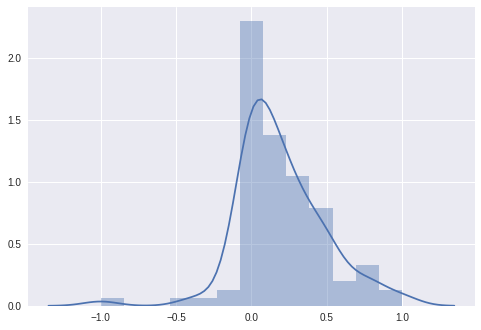

In [5]:
# Let's plot these sentiments!
sns.distplot(sentiment_scores)

We can see that a majority of the comments are marked as neutral (though slightly on the positive side). This basically implies that TextBlob SA 'averages' out over a sentence. 

So for a sentence containing : "Love your videos and humor." the polarity is 0.167 plainly because it is also followed by "curiously once training is complete how do you feed a movie review into the model or access the model ie where is model saved at the completion of training".

Let's now try aspect based SA and see if we get better results!

In [6]:
# Convert array of comments into a single string
comments = TextBlob(' '.join(result))

In [7]:
# Check out noun phrases, will be useful for frequent feature extraction
comments.noun_phrases

WordList(['shows clearer', 'input reviews', 'intermediate level understanding', 'conceptual bits', 'high levelcould', 'fundamental concepts btw', 'nice rap p.', 'text editor', 'python version361 anaconda440 code', 'german i', 'waldeinsamkeit p iv', 'neural net', 'hi siraj i', 'small mistake', 'validationset textx texty', 'nt work', 'validationset textx testy', 'i m', 'new text', 'i d', 'i m', 'real world problems', 'i ca nt', 'movie review', 'awesome videso', 'background research im', 'imdb database', 'storage format', 'ai pleb', 'hey siraj i', 'error list index', 'case i', 'current state', 'sentiment analysis', 'size thats', 'i download code', 'nnet architecture', 'wow i', 'catchy informative', 'just awesome course i', 'absolute popularity', 'integers source', 'name validationset', 'neural net', 'btw thanks', 'great videos', 'image recognition', 'теперь я знаю что случилось с рилигетард хаха', 'забавно но понятно зачем менять', 'сегодня было бы трудно быть общественным деятелем и выра

# Pruning

Quite a lot of these noun phrases are repeated or have the same subset of words. We now run modified versions of  redundancy pruning and compactness pruning.

## Compactness pruning: 

We check for compact phrases and see if the words in the phrases make sense. For e.g the phrase "i m" fails the compact pruning test and is pruned. A simple way to carry out compact pruning is by checking the words in a phrase and seeing if a dictionary meaning exists. If the number of words in the phrase without dictionary meanings cross a certain threshold, we prune the phrase. (This can be counter-intuitive at times, because technical terms that do not have a dictionary meaning can get pruned).

In [8]:
#compactness pruning:
cleaned = list()
for phrase in comments.noun_phrases:
    count = 0
    for word in phrase.split():
        # Count the number of small words and words without an English definition
        if len(word) <= 2 or (not Word(word).definitions):
            count += 1
    # Only if the 'nonsensical' or short words DO NOT make up more than 40% (arbitrary) of the phrase add
    # it to the cleaned list, effectively pruning the ones not added.
    if count < len(phrase.split())*0.4:
        cleaned.append(phrase)
        
print("After compactness pruning:\nFeature Size:")
len(cleaned)

After compactness pruning:
Feature Size:


125


## Redundancy pruning:
I am using a naive decision of choosing the _largest common noun phrase_ as a non-redundant feature. A better way would be to find 'important' terms in common noun phrases and choose those. One approach to that could be something called TF-IDF (more about that [here](http://stevenloria.com/finding-important-words-in-a-document-using-tf-idf/)).

In [9]:
for phrase in cleaned:    
    match = list()
    temp = list()
    word_match = list()
    for word in phrase.split():
        # Find common words among all phrases
        word_match = [p for p in cleaned if re.search(word, p) and p not in word_match]
        # If the size of matched phrases set is smaller than 30% of the cleaned phrases, 
        # then consider the phrase as non-redundant.
        if len(word_match) <= len(cleaned)*0.3 :
            temp.append(word)
            match += word_match
            
    phrase = ' '.join(temp)
#     print("Match for " + phrase + ": " + str(match))

    if len(match) >= len(cleaned)*0.1 :
        # Redundant feature set, since it contains more than 10% of the number of phrases. 
        # Prune all matched features.
        for feature in match:
            if feature in cleaned:
                cleaned.remove(feature)
            
        # Add largest length phrase as feature
        cleaned.append(max(match, key=len))
        

print("After redundancy pruning:\nFeature Size:" + str(len(cleaned)))
print("Cleaned features:")
cleaned


After redundancy pruning:
Feature Size:78
Cleaned features:


['shows clearer',
 'input reviews',
 'intermediate level understanding',
 'conceptual bits',
 'fundamental concepts btw',
 'nice rap p.',
 'neural net',
 'small mistake',
 'real world problems',
 'movie review',
 'error list index',
 'current state',
 'i download code',
 'just awesome course i',
 'absolute popularity',
 'integers source',
 'neural net',
 'accuracy score',
 'cool stuff',
 'buddhist vipassana tradition',
 'dark night',
 'code trains',
 'new phrases',
 'new data inputs',
 'conceptual side',
 'quick cuts',
 'inexplicable reason',
 'jurassic park scene',
 'nice video',
 'new delhi india',
 'computer science',
 'college project',
 'naive bayes',
 'main area',
 'specific reviews',
 'final year project',
 'pro series',
 'previous video',
 'right predictions anyways i',
 'such thing',
 'dependency thing',
 'size vectors',
 'lstm need use',
 'input neural net word',
 'neural net',
 'index representation',
 'input vector',
 'possible output values',
 'raw word',
 'super awesome v

We now find the noun phrases with maximum frequencies and select the "frequent feature set" using a certain cutoff.

In [10]:
from nltk.corpus import stopwords
feature_count = dict()
for phrase in cleaned:
    count = 0
    for word in phrase.split():
        if word not in stopwords.words('english'):
            count += comments.words.count(word)
    
    print(phrase + ": " + str(count))
    feature_count[phrase] = count

shows clearer: 2
input reviews: 11
intermediate level understanding: 4
conceptual bits: 3
fundamental concepts btw: 5
nice rap p.: 7
neural net: 10
small mistake: 2
real world problems: 4
movie review: 4
error list index: 7
current state: 2
i download code: 13
just awesome course i: 7
absolute popularity: 2
integers source: 3
neural net: 10
accuracy score: 2
cool stuff: 5
buddhist vipassana tradition: 3
dark night: 2
code trains: 12
new phrases: 8
new data inputs: 13
conceptual side: 4
quick cuts: 2
inexplicable reason: 2
jurassic park scene: 3
nice video: 18
new delhi india: 9
computer science: 2
college project: 6
naive bayes: 2
main area: 2
specific reviews: 3
final year project: 7
pro series: 3
previous video: 16
right predictions anyways i: 5
such thing: 4
dependency thing: 6
size vectors: 3
lstm need use: 16
input neural net word: 25
neural net: 10
index representation: 5
input vector: 12
possible output values: 7
raw word: 7
super awesome video: 23
side effect tflearn: 10
fat be

In [11]:
# Select frequent feature threshold as (max_count)/100 
# This is an arbitrary decision as of now.
counts = list(feature_count.values())
features = list(feature_count.keys())
threshold = len(comments.noun_phrases)/100

print("Threshold:" + str(threshold))

frequent_features = list()

for feature, count in feature_count.items():
    if count >= threshold:
        frequent_features.append(feature)
        
print('Frequent Features:')
frequent_features

Threshold:2.25
Frequent Features:


['input reviews',
 'intermediate level understanding',
 'conceptual bits',
 'fundamental concepts btw',
 'nice rap p.',
 'neural net',
 'real world problems',
 'movie review',
 'error list index',
 'i download code',
 'just awesome course i',
 'integers source',
 'cool stuff',
 'buddhist vipassana tradition',
 'code trains',
 'new phrases',
 'new data inputs',
 'conceptual side',
 'jurassic park scene',
 'nice video',
 'new delhi india',
 'college project',
 'specific reviews',
 'final year project',
 'pro series',
 'previous video',
 'right predictions anyways i',
 'such thing',
 'dependency thing',
 'size vectors',
 'lstm need use',
 'input neural net word',
 'index representation',
 'input vector',
 'possible output values',
 'raw word',
 'super awesome video',
 'side effect tflearn',
 'good work',
 'output results',
 'baby activation functionstrack',
 'life video',
 'code challenge submission',
 'challenge code',
 'git repo pip install git',
 'dependency curses',
 'normal python sc

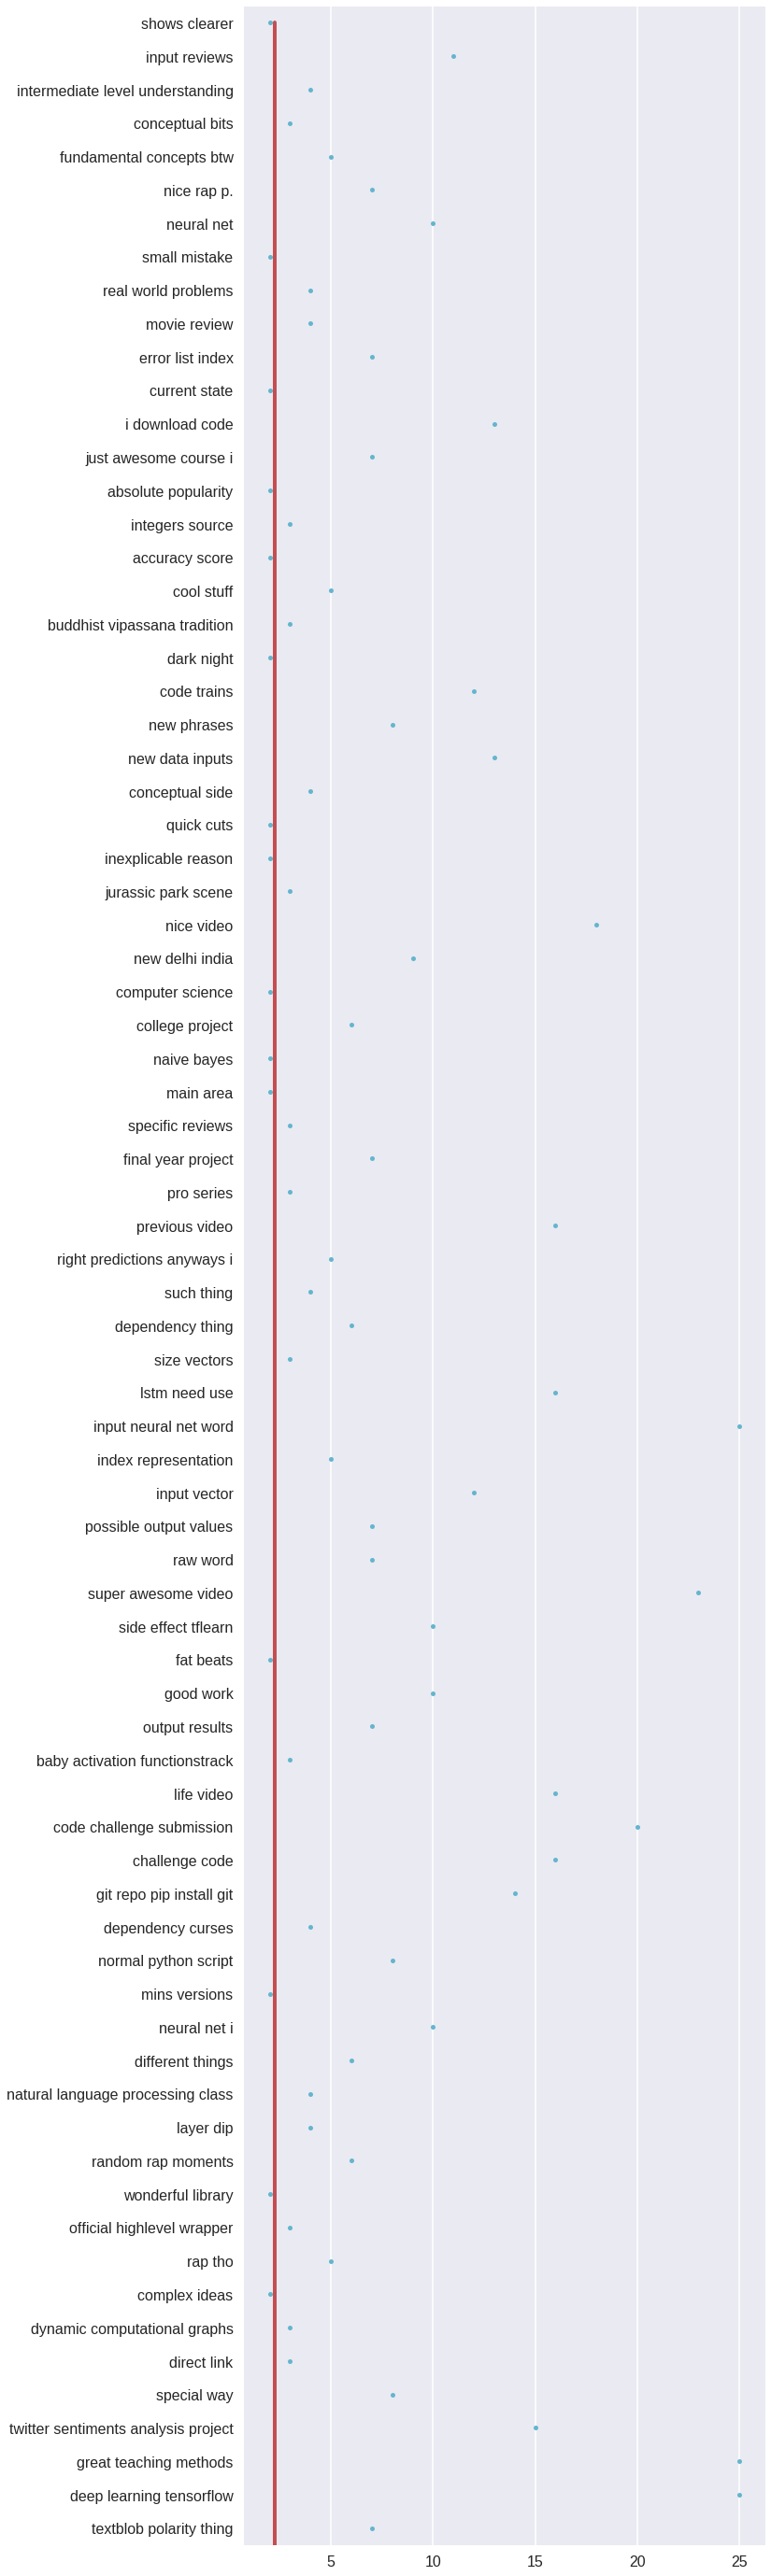

In [12]:
# Let's plot these feature occurences and draw the threshold line
sns.set()
sns.set_context("poster")
f, ax = plt.subplots(figsize=(10, 50))
sns.swarmplot(y=features, x=counts, color="c", ax=ax)
plt.plot([threshold, threshold], [0, len(features)], linewidth=4, color="r")

## Feature Specific Sentiment Analysis
Now that we have the frequent features, we scan through the comments and find the sentences that contain these features. We then run sentiment analysis on these 'feature specific' sentences to get somewhat crude feature based sentiment scores. Further refinement will include generalizing the features, for e.g: "wonderful python library" could be generalized to "software", which will eventually lead to aspect wise sentiment scores.

In [13]:
absa_list = dict()
# For each frequent feature
for f in frequent_features:
    # For each comment
    absa_list[f] = list()
    for comment in result:
        blob = TextBlob(comment)
        # For each sentence of the comment
        for sentence in blob.sentences:
            # Search for frequent feature 'f'
            q = '|'.join(f.split())
            if re.search(r'\w*(' + str(q) + ')\w*', str(sentence)):
                absa_list[f].append(sentence)


# print("Aspect Specific sentences:")
# absa_list

## Aspect based sentiment scoring
Now that we have aspect specific sentences, all we have to do is run sentiment analysis on each sentence using TextBlob's sentiment analyzer.


In [14]:
scores = list()
absa_scores = dict()
for k, v in absa_list.items():
    absa_scores[k] = list()
    for sent in v:
        score = sent.sentiment.polarity
        scores.append(score)
        absa_scores[k].append(score)

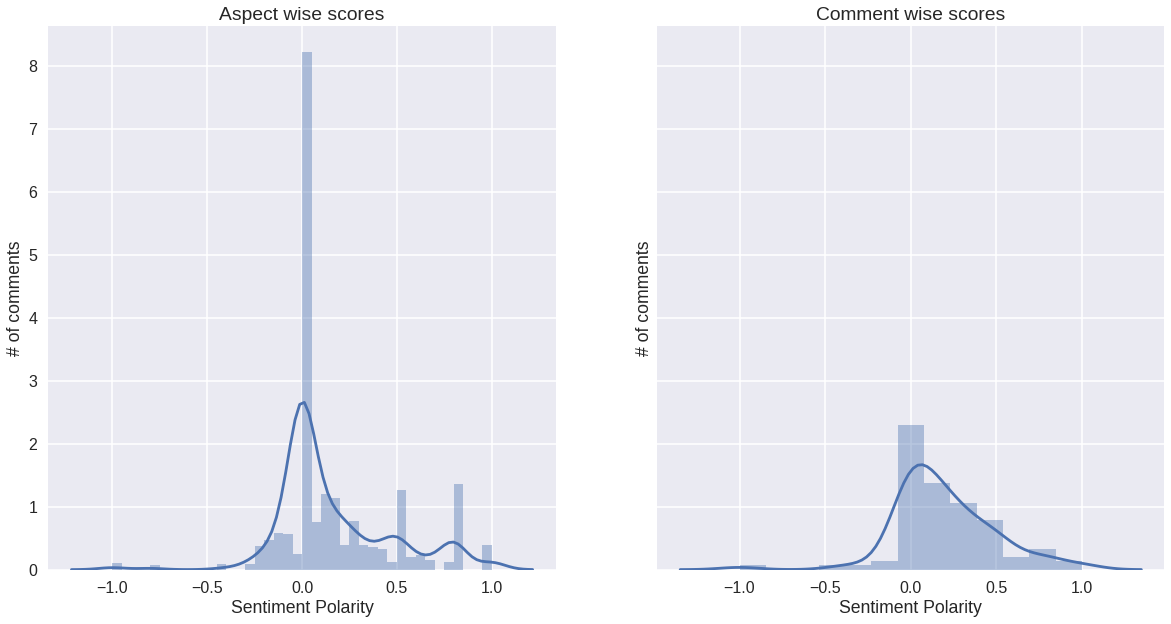

In [15]:
# Now that we have all the scores, let's plot them!
# For comparison, we replot the previous global sentiment polarity plot
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(20, 10))
plot1 = sns.distplot(scores, ax=ax1)

ax1.set_title('Aspect wise scores')
ax1.set_xlabel('Sentiment Polarity')
ax1.set_ylabel('# of comments')

ax2.set_title('Comment wise scores')
ax2.set_xlabel('Sentiment Polarity')
ax2.set_ylabel('# of comments')

plot2 = sns.distplot(sentiment_scores, ax=ax2)

## Graph Analysis
Notice the high amount of variance in the aspect based scores on the left. Even though a majority of the scores are neutral, there is lot of variance in the number of comments with positive sentiments. The total number of scores have also increased since one sentence of a comment may contain multiple frequent features.

Now let's plot the scores grouped by aspects.


In [16]:
# Create data values for stripplot and boxplot
vals = dict()
vals["aspects"] = list()
vals["scores"] = list()
for k, v in absa_scores.items():
    for score in v:
        vals["aspects"].append(k)
        vals["scores"].append(score)

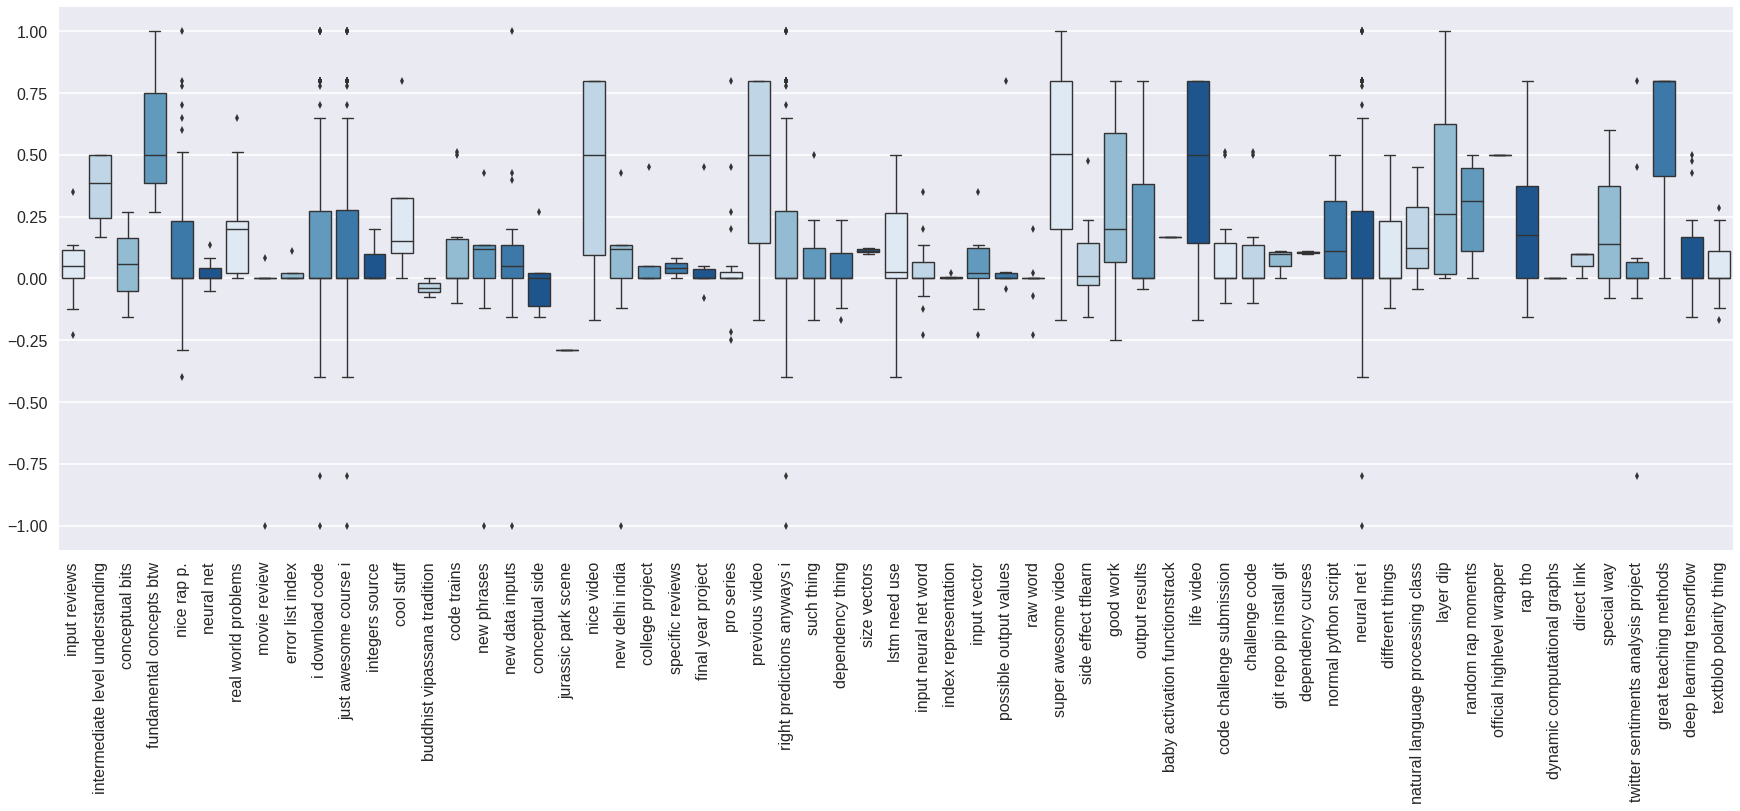

In [17]:
fig, ax1 = plt.subplots(figsize=(30, 10))

color = sns.color_palette("Blues", 6)
plt.xticks(rotation=90)
sns.set_context("paper", font_scale=3) 
sns.boxplot(x="aspects", y="scores", data=vals, palette=color, ax=ax1)

Now we see the real strength of Aspect Based Sentiment Analysis. The box plots show a large amount of variance among sentiments across a variety of aspects. Keep in mind though, the aspects have been chosen based on frequency of noun phrases, so some of the phrases may not make sense (I am looking at you, "baby activation functionstrack").

Nevertheless, this goes to show that carrying out sentiment analysis on aspects provides much more information than  normal sentiment analysis. Also, we take a naive approach of picking the largest noun phrase as the aspect, which may not be the best assumption for all cases. For e.g, an aspect "project" would be better than "twitter sentiment analysis project", which works against my assumption.

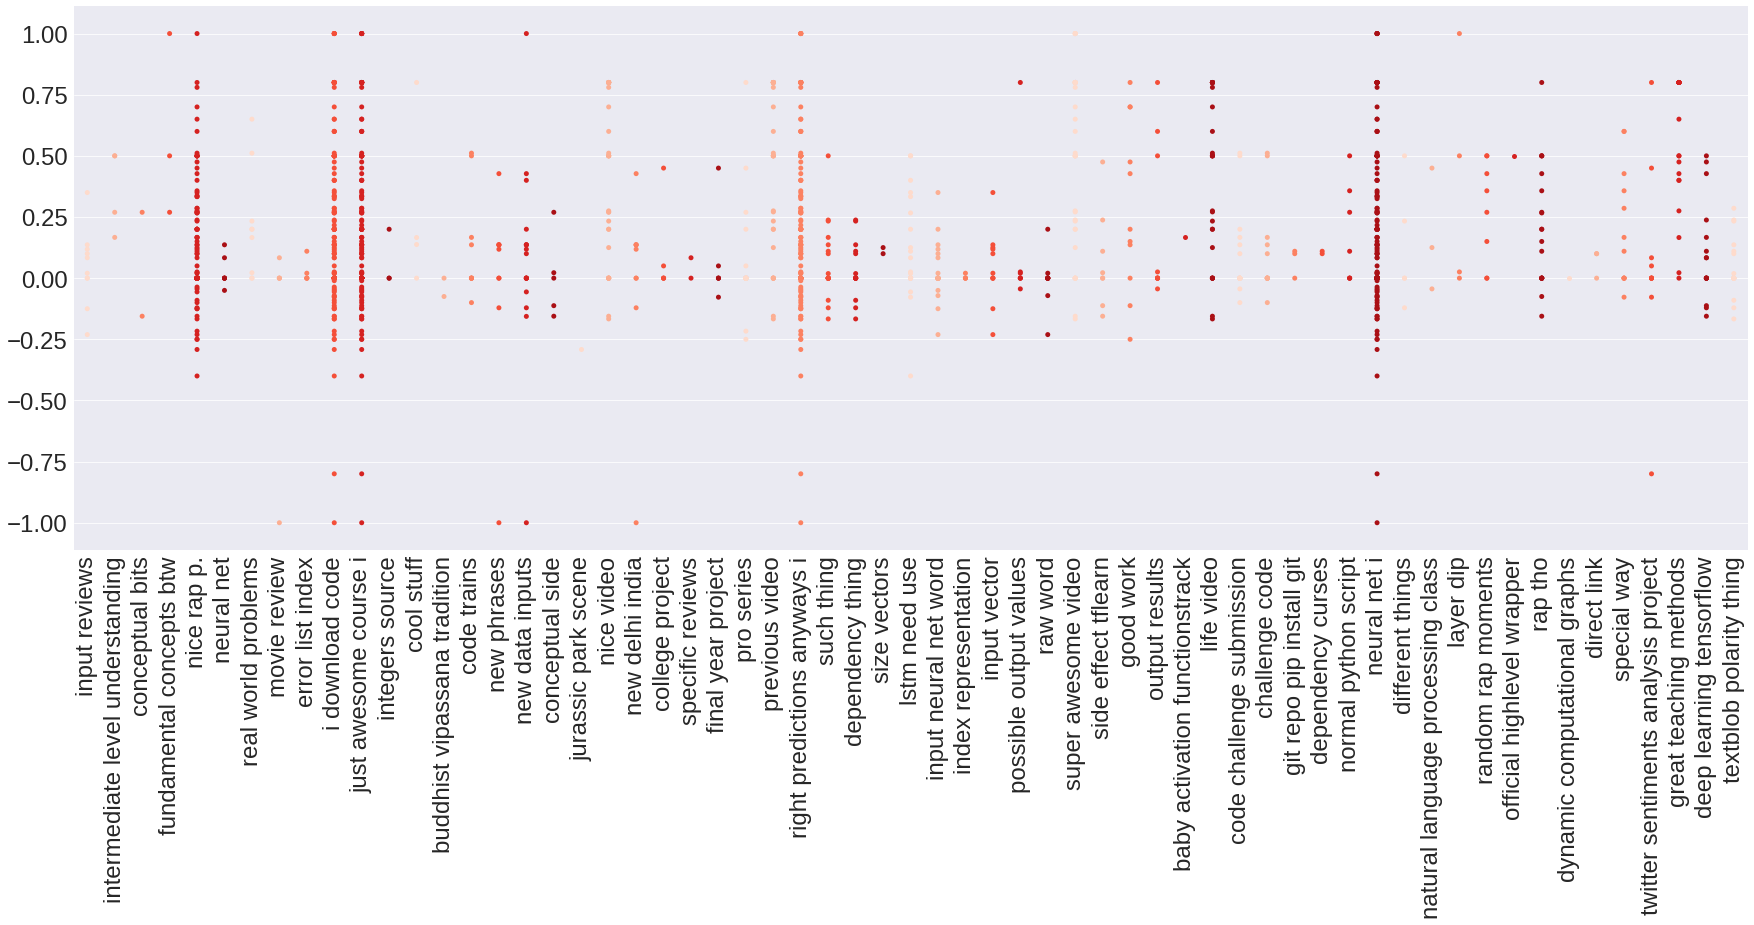

In [18]:
color = sns.color_palette("Reds", 6)
fig, ax1 = plt.subplots(figsize=(30, 10))
plt.xticks(rotation=90)
sns.set_context("paper", font_scale=2) 
sns.stripplot(x="aspects", y="scores",data=vals, palette=color)

# Conclusion
I ran Aspect Based Sentiment Analysis (ABSA) on a YouTube [video](https://www.youtube.com/watch?v=si8zZHkufRY) and found that ABSA actually gives a more in-depth understanding of people's reviews.

The sentiment scores have a large variance as compared to 'global' sentiment analysis. There are a lot of assumptions in the algorithms, but I hope the process proves the point that analyzing reviews/comments and scoring them as per the aspects that the reviewers talk about is more beneficial for the creator than conventional Sentiment Analysis.

I hope this notebook has been informative and useful. If you are interested in Aspect Based Sentiment Analysis, you can check out [this](http://www.aclweb.org/anthology/S15-2082) paper. You can also check out the [SemEval](http://alt.qcri.org/semeval2016/task5/) task for Aspect Based Sentiment Analysis.